In [1]:
import pandas as pd
import numpy as np

from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE,RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("/Users/Oğuz/Desktop/selenium/T1total.csv")

data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
filtered_data = data[(data['TimeStamp'] >= '2019-01-01') & (data['TimeStamp'] < '2020-01-01')]

filtered_data.head()

,TimeStamp,WindSpeed,WindDirection,PitchAngle,Temperature,Power
0,2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994
1,2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,213.300003
2,2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,164.100006
3,2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,21.799999
4,2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,48.299999


In [4]:
russia = []
i = 0
while i < len(filtered_data):
    russia.append(filtered_data.loc[i])
    i = i + 6
filtered_datas = pd.DataFrame(russia)
filtered_datas.head()

,TimeStamp,WindSpeed,WindDirection,PitchAngle,Temperature,Power
0,2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994
6,2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002
12,2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994
18,2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000
24,2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024


In [5]:
# Boş değerleri tespit etme
missing_values = filtered_datas.isnull().sum()
print(missing_values)

TimeStamp         0
WindSpeed        63
WindDirection    63
PitchAngle       63
Temperature      63
Power            63
dtype: int64


In [6]:
# Eksik değerleri kaldırma
temizdata = filtered_datas.dropna()
missing_values = temizdata.isnull().sum()
temizdata.set_index('TimeStamp', inplace=True)
print(missing_values)
# Temizlenmiş veri setinin ilk birkaç satırını görüntüleme
temizdata.head()

TimeStamp        0
WindSpeed        0
WindDirection    0
PitchAngle       0
Temperature      0
Power            0
dtype: int64


,WindSpeed,WindDirection,PitchAngle,Temperature,Power
TimeStamp,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994
2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002
2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994
2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000
2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024


In [29]:
temizdata.boxplot()

<Axes: >

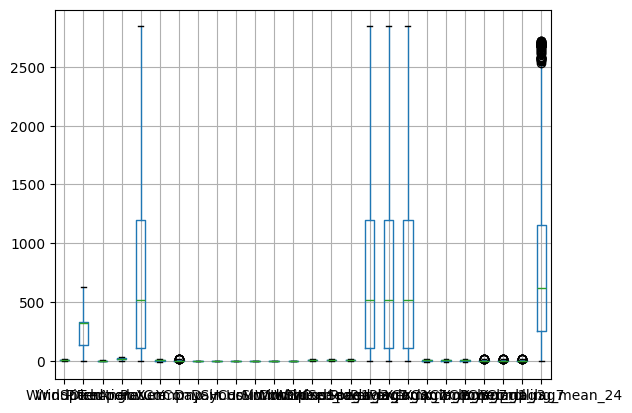

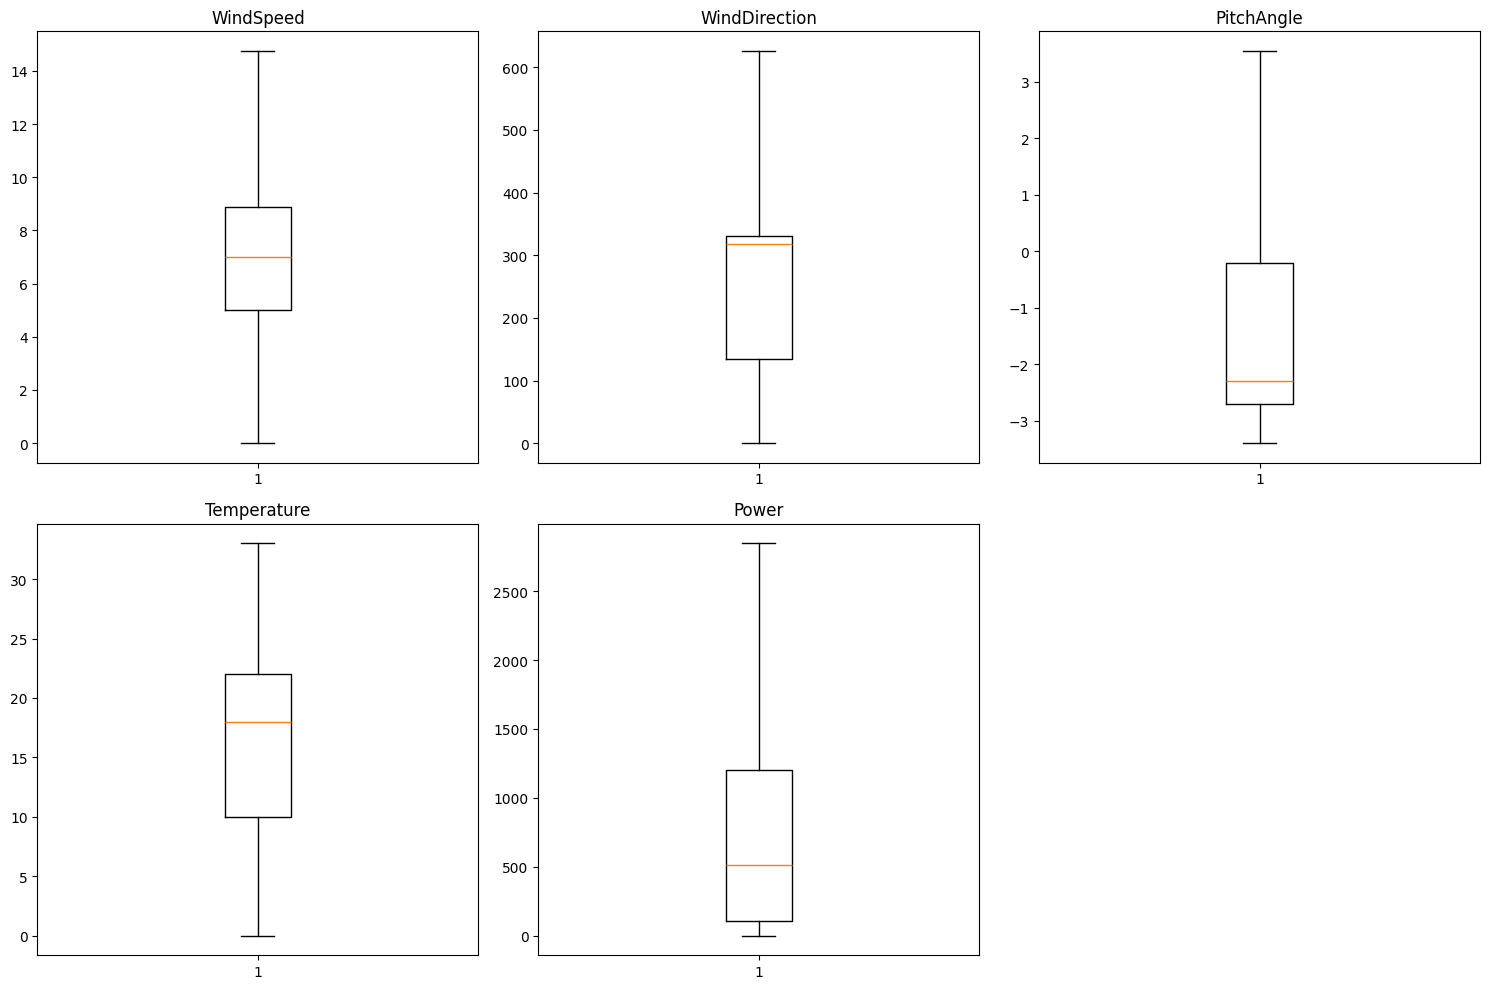

In [30]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.boxplot(temizdata['WindSpeed'])
plt.title('WindSpeed')

plt.subplot(2, 3, 2)
plt.boxplot(temizdata['WindDirection'])
plt.title('WindDirection')

plt.subplot(2, 3, 3)
plt.boxplot(temizdata['PitchAngle'])
plt.title('PitchAngle')

plt.subplot(2, 3, 4)
plt.boxplot(temizdata['Temperature'])
plt.title('Temperature')

plt.subplot(2, 3, 5)
plt.boxplot(temizdata['Power'])
plt.title('Power')

plt.tight_layout()
plt.show()

In [9]:
# IQR metodunu kullanarak aykırı değerleri sınırlama
for column in temizdata.columns:
    data_column = temizdata[column]
    q1 = np.percentile(data_column, 25)
    q3 = np.percentile(data_column, 75)
    IQR = q3 - q1
    uplimit = q3 + 1.5 * IQR
    lowlimit = q1 - 1.5 * IQR
    temizdata.loc[temizdata[column] > uplimit, column] = uplimit
    temizdata.loc[temizdata[column] < lowlimit, column] = lowlimit

temizdata.loc[temizdata['Power'] < 0, 'Power'] = 0


C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1409694516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temizdata.loc[temizdata[column] > uplimit, column] = uplimit
C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1409694516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temizdata.loc[temizdata[column] < lowlimit, column] = lowlimit
C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1409694516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [10]:
temizdata["WindDirectionRad"] = np.deg2rad(temizdata["WindDirection"])
temizdata["XComp"] = temizdata["WindSpeed"] * np.cos(temizdata["WindDirectionRad"])
temizdata["YComp"] = temizdata["WindSpeed"] * np.sin(temizdata["WindDirectionRad"])
temizdata = temizdata.drop(columns=["WindDirectionRad"])


C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1240047455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temizdata["WindDirectionRad"] = np.deg2rad(temizdata["WindDirection"])
C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1240047455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temizdata["XComp"] = temizdata["WindSpeed"] * np.cos(temizdata["WindDirectionRad"])
C:\Users\Oğuz\AppData\Local\Temp\ipykernel_2568\1240047455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [11]:
temizdata.head()

,WindSpeed,WindDirection,PitchAngle,Temperature,Power,XComp,YComp
TimeStamp,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994,-4.390506,2.786299
2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002,-3.490135,2.336442
2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994,-3.725022,3.027244
2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000,-2.950000,5.109550
2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024,-3.429121,5.987581


In [12]:
temizdata['Hour'] = temizdata.index.hour
temizdata['Day'] = temizdata.index.day
temizdata['Month'] = temizdata.index.month

In [13]:
temizdata['DaySin'] = np.sin(temizdata['Day'] * (2. * np.pi / 31))
temizdata['DayCos'] = np.cos(temizdata['Day'] * (2. * np.pi / 31))
temizdata['HourSin'] = np.sin(temizdata['Hour'] * (2. * np.pi / 24))
temizdata['HourCos'] = np.cos(temizdata['Hour'] * (2. * np.pi / 24))
temizdata['MonthSin'] = np.sin((temizdata['Month'] - 1) * (2. * np.pi / 12))
temizdata['MonthCos'] = np.cos((temizdata['Month'] - 1) * (2. * np.pi / 12))
temizdata = temizdata.drop(columns=['Day', 'Hour', 'Month'])

In [14]:
temizdata.head()

,WindSpeed,WindDirection,PitchAngle,Temperature,Power,XComp,YComp,DaySin,DayCos,HourSin,HourCos,MonthSin,MonthCos
TimeStamp,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994,-4.390506,2.786299,0.201299,0.97953,0.000000,1.000000,0.0,1.0
2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002,-3.490135,2.336442,0.201299,0.97953,0.258819,0.965926,0.0,1.0
2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994,-3.725022,3.027244,0.201299,0.97953,0.500000,0.866025,0.0,1.0
2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000,-2.950000,5.109550,0.201299,0.97953,0.707107,0.707107,0.0,1.0
2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024,-3.429121,5.987581,0.201299,0.97953,0.866025,0.500000,0.0,1.0


In [15]:
# Lag gecikmelerini 1, 3 ve 7 olarak ekleme
lags = [1, 3, 7]
for column in ['WindSpeed', 'Power', 'XComp', 'YComp']:
    for lag in lags:
        temizdata[f'{column}_lag{lag}'] = temizdata[column].shift(lag)

temizdata = temizdata.fillna(0)


In [16]:
temizdata.head()

,WindSpeed,WindDirection,PitchAngle,Temperature,Power,XComp,YComp,DaySin,DayCos,HourSin,HourCos,MonthSin,MonthCos,WindSpeed_lag1,WindSpeed_lag3,WindSpeed_lag7,Power_lag1,Power_lag3,Power_lag7,XComp_lag1,XComp_lag3,XComp_lag7,YComp_lag1,YComp_lag3,YComp_lag7
TimeStamp,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994,-4.390506,2.786299,0.201299,0.97953,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002,-3.490135,2.336442,0.201299,0.97953,0.258819,0.965926,0.0,1.0,5.2,0.0,0.0,180.899994,0.000000,0.0,-4.390506,0.000000,0.0,2.786299,0.000000,0.0
2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994,-3.725022,3.027244,0.201299,0.97953,0.500000,0.866025,0.0,1.0,4.2,0.0,0.0,79.400002,0.000000,0.0,-3.490135,0.000000,0.0,2.336442,0.000000,0.0
2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000,-2.950000,5.109550,0.201299,0.97953,0.707107,0.707107,0.0,1.0,4.8,5.2,0.0,144.399994,180.899994,0.0,-3.725022,-4.390506,0.0,3.027244,2.786299,0.0
2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024,-3.429121,5.987581,0.201299,0.97953,0.866025,0.500000,0.0,1.0,5.9,4.2,0.0,333.000000,79.400002,0.0,-2.950000,-3.490135,0.0,5.109550,2.336442,0.0


In [17]:
temizdata['Power_rolling_mean_24'] = temizdata['Power'].rolling(window=24).mean()
temizdata['Power_rolling_mean_24'] = temizdata['Power_rolling_mean_24'].fillna(0)


In [18]:
temizdata.head()

,WindSpeed,WindDirection,PitchAngle,Temperature,Power,XComp,YComp,DaySin,DayCos,HourSin,HourCos,MonthSin,MonthCos,WindSpeed_lag1,WindSpeed_lag3,WindSpeed_lag7,Power_lag1,Power_lag3,Power_lag7,XComp_lag1,XComp_lag3,XComp_lag7,YComp_lag1,YComp_lag3,YComp_lag7,Power_rolling_mean_24
TimeStamp,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994,-4.390506,2.786299,0.201299,0.97953,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2019-01-01 01:00:00,4.2,146.199997,-0.6,5.0,79.400002,-3.490135,2.336442,0.201299,0.97953,0.258819,0.965926,0.0,1.0,5.2,0.0,0.0,180.899994,0.000000,0.0,-4.390506,0.000000,0.0,2.786299,0.000000,0.0,0.0
2019-01-01 02:00:00,4.8,140.899994,-1.4,5.0,144.399994,-3.725022,3.027244,0.201299,0.97953,0.500000,0.866025,0.0,1.0,4.2,0.0,0.0,79.400002,0.000000,0.0,-3.490135,0.000000,0.0,2.336442,0.000000,0.0,0.0
2019-01-01 03:00:00,5.9,120.000000,-2.2,5.0,333.000000,-2.950000,5.109550,0.201299,0.97953,0.707107,0.707107,0.0,1.0,4.8,5.2,0.0,144.399994,180.899994,0.0,-3.725022,-4.390506,0.0,3.027244,2.786299,0.0,0.0
2019-01-01 04:00:00,6.9,119.800003,-1.8,5.0,537.400024,-3.429121,5.987581,0.201299,0.97953,0.866025,0.500000,0.0,1.0,5.9,4.2,0.0,333.000000,79.400002,0.0,-2.950000,-3.490135,0.0,5.109550,2.336442,0.0,0.0


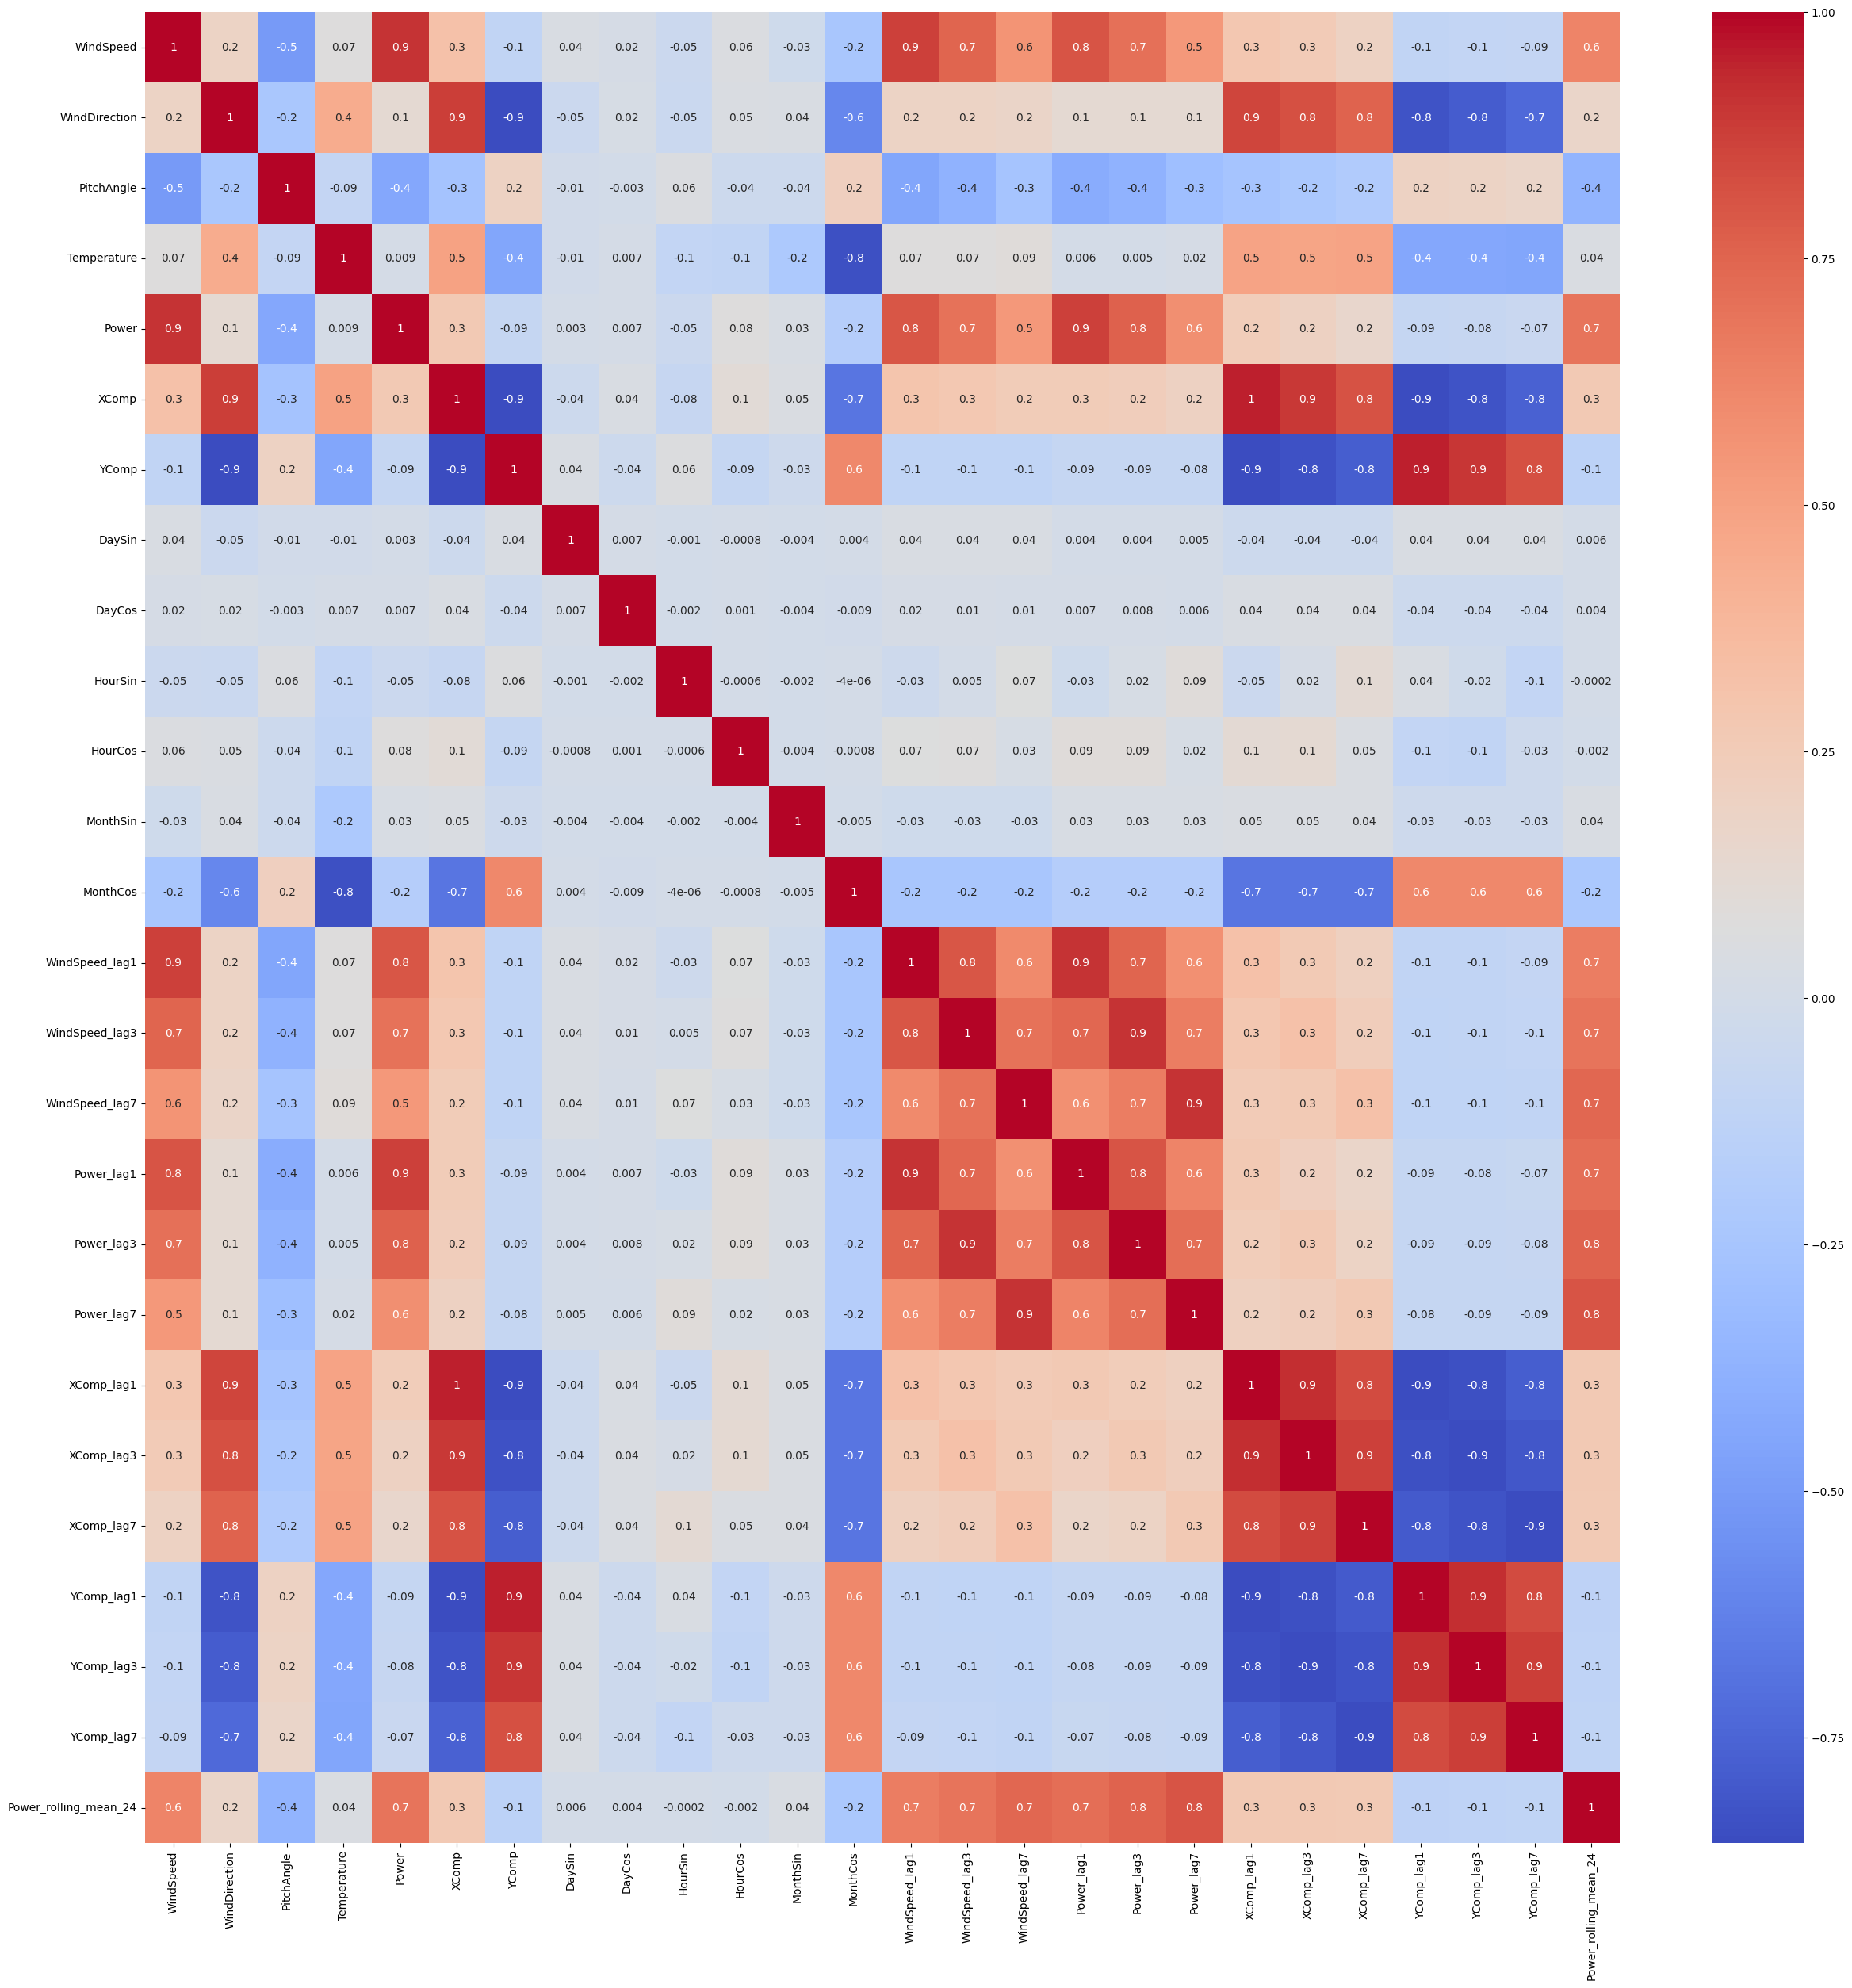

In [19]:
#Feature Selection with correlation values
corr = temizdata.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, fmt='.1g', cmap='coolwarm')
plt.show()

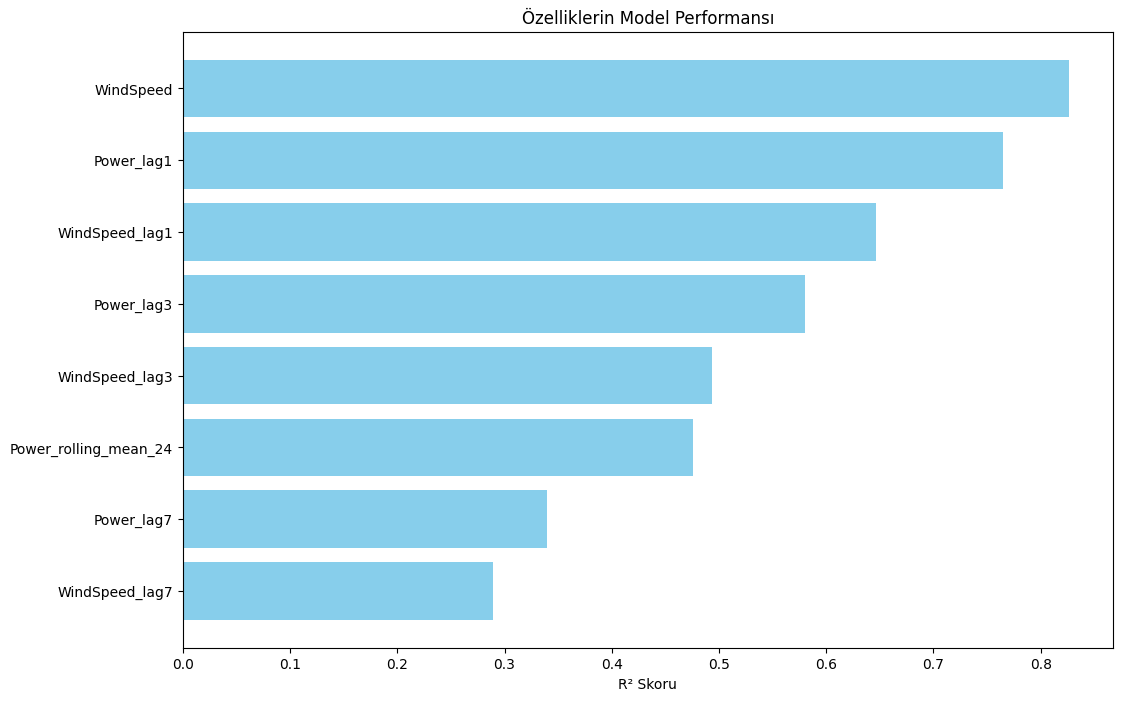

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Hedef değişken ve özellikleri ayırma
X = temizdata.drop(columns=['Power'])
y = temizdata['Power']

# Model oluşturma
model = LinearRegression()

# Özellik performansını saklamak için bir liste
feature_performance = []

# Her bir özelliği tek tek kullanarak model performansını ölçme
for feature in X.columns:
    X_single = X[[feature]]
    model.fit(X_single, y)
    y_pred = model.predict(X_single)
    score = r2_score(y, y_pred)
    feature_performance.append((feature, score))

# Performansa göre özellikleri sıralama
feature_performance.sort(key=lambda x: x[1], reverse=True)

# Performans sonuçlarını bir DataFrame'e dönüştürme
performance_df = pd.DataFrame(feature_performance, columns=['Feature', 'R2_Score'])
# En yüksek R² skoruna sahip ilk 10 özelliği seçme
top_features = performance_df.head(8)
# Grafiği oluşturma
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['R2_Score'], color='skyblue')
plt.xlabel('R² Skoru')
plt.title('Özelliklerin Model Performansı')
plt.gca().invert_yaxis()
plt.show()


# GÖRSELLEŞTİRME & ANALİZ

In [21]:
temizdata.describe()

,WindSpeed,WindDirection,PitchAngle,Temperature,Power,XComp,YComp,DaySin,DayCos,HourSin,HourCos,MonthSin,MonthCos,WindSpeed_lag1,WindSpeed_lag3,WindSpeed_lag7,Power_lag1,Power_lag3,Power_lag7,XComp_lag1,XComp_lag3,XComp_lag7,YComp_lag1,YComp_lag3,YComp_lag7,Power_rolling_mean_24
count,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8.697000e+03,8697.000000,8.697000e+03,8.697000e+03,8697.000000,8.697000e+03,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000,8697.000000
mean,6.976342,249.200241,-1.012458,15.994366,750.115287,2.459102,-0.543353,4.623440e-03,-0.021005,4.292575e-04,1.705101e-03,0.002542,-4.496392e-03,6.976112,6.975377,6.974342,750.115287,750.106238,750.106238,2.459189,2.459662,2.459188,-0.543566,-0.543020,-0.542478,748.536194
std,2.821409,100.019358,2.520572,6.898601,755.389746,5.079723,4.948592,7.139122e-01,0.699987,7.072232e-01,7.070695e-01,0.704903,7.093657e-01,2.821896,2.823257,2.825391,755.389746,755.398262,755.398262,5.079675,5.079349,5.079409,4.948529,4.948427,4.948420,590.651430
min,0.000000,0.200000,-3.400000,0.000000,0.000000,-13.098384,-14.633691,-9.987165e-01,-0.994869,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.098384,-13.098384,-13.098384,-14.633691,-14.633691,-14.633691,0.000000
25%,5.000000,134.300003,-2.700000,10.000000,103.900002,-2.562234,-4.263012,-7.247928e-01,-0.758758,-7.071068e-01,-7.071068e-01,-0.500000,-8.660254e-01,5.000000,5.000000,5.000000,103.900002,103.900002,103.900002,-2.562234,-2.562234,-2.562234,-4.263012,-4.263012,-4.263012,252.020833
50%,7.000000,318.299988,-2.300000,18.000000,515.799988,4.260055,-2.156497,-2.449294e-16,-0.050649,1.224647e-16,6.123234e-17,0.000000,-1.836970e-16,7.000000,7.000000,7.000000,515.799988,515.799988,515.799988,4.260055,4.260055,4.260055,-2.156497,-2.156287,-2.156287,616.245824
75%,8.900000,331.000000,-0.200000,22.000000,1201.000000,6.748181,3.339162,7.247928e-01,0.688967,7.071068e-01,7.071068e-01,0.866025,5.000000e-01,8.900000,8.900000,8.900000,1201.000000,1201.000000,1201.000000,6.748181,6.748181,6.748181,3.339162,3.339162,3.339162,1158.545832
max,14.750000,626.049996,3.550000,33.000000,2846.649997,13.400494,14.750000,9.987165e-01,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,14.750000,14.750000,14.750000,2846.649997,2846.649997,2846.649997,13.400494,13.400494,13.400494,14.750000,14.750000,14.750000,2721.943741


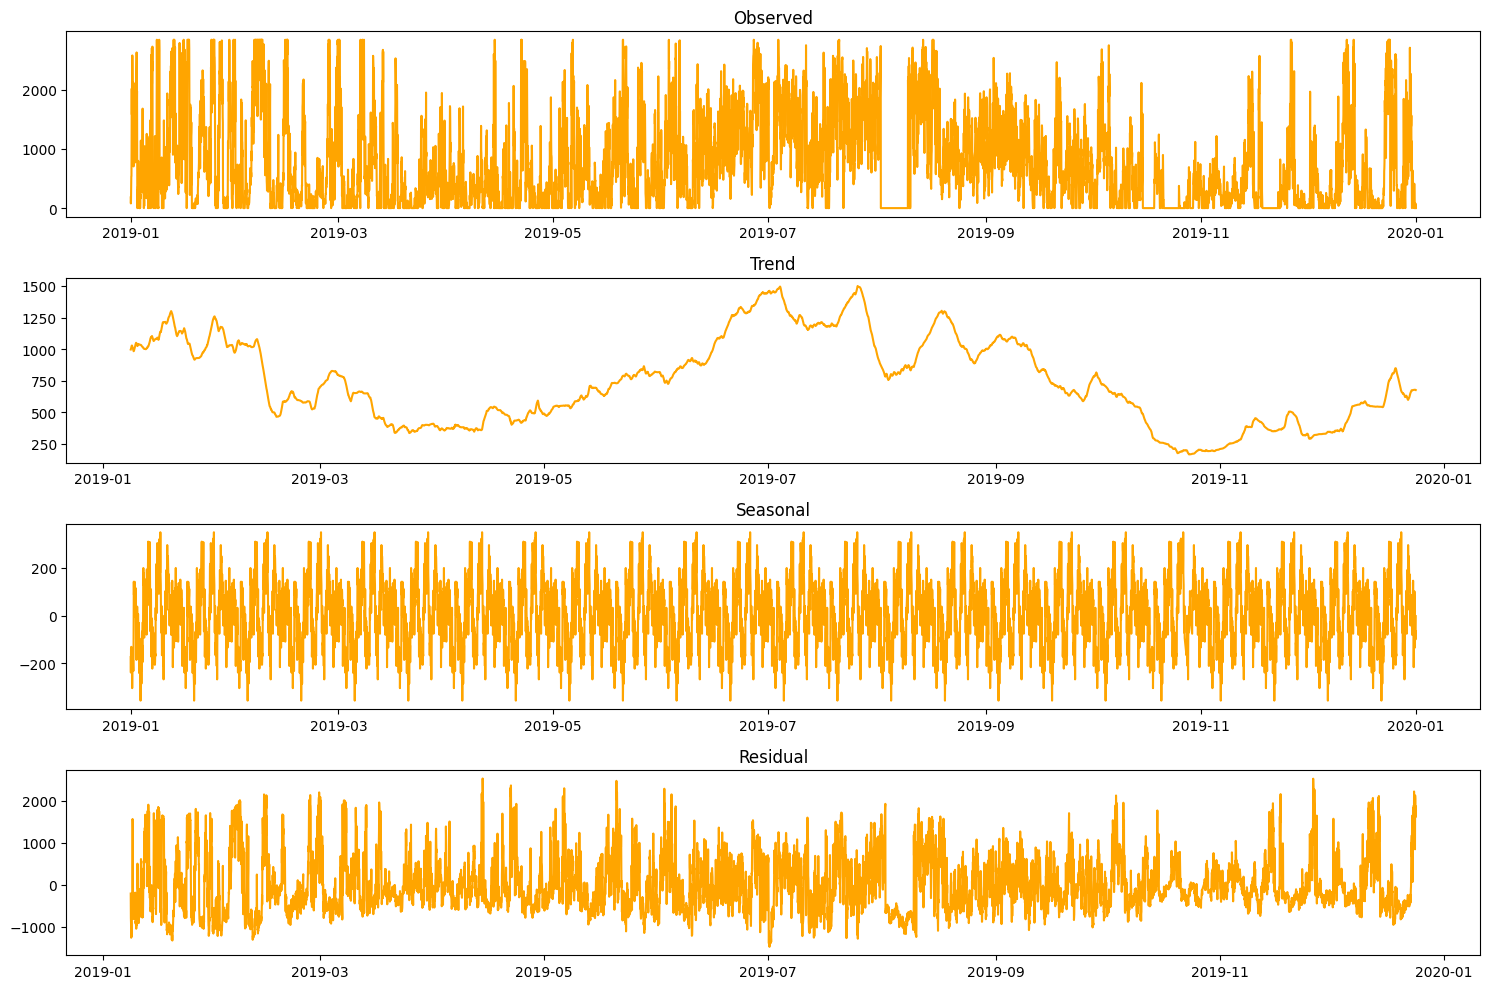

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
power_series = temizdata['Power']

# Mevsimsellik ve trend analizi için seasonal_decompose fonksiyonunu kullanalım
decomposition = seasonal_decompose(power_series, model='additive', period=365)

# Bileşenleri görselleştirelim
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(decomposition.observed, color ='orange')
ax1.set_title('Observed')
ax2.plot(decomposition.trend, color ='orange')
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal, color ='orange')
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid, color ='orange')
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

#### Mevsimsellik ve trend analizi sonuçları:

Observed (Gözlemlenen): Verinin tüm bileşenlerini içerir.

Trend: Uzun vadeli değişiklikleri gösterir. Belirli dönemlerde artış ve azalmalar gözlemlenebilir.

Seasonal (Mevsimsel): Düzenli olarak tekrarlayan desenleri gösterir. Veride belirli bir mevsimsellik deseni mevcut.

Residual (Artık): Geri kalan değişkenliği gösterir, yani verideki rastgele varyasyonlar.

Bu analizle, verinizde belirgin bir trend ve mevsimsellik olduğunu görebilirsiniz. Bu bulgular, zaman serisi modellemesi yaparken önemli olabilir.

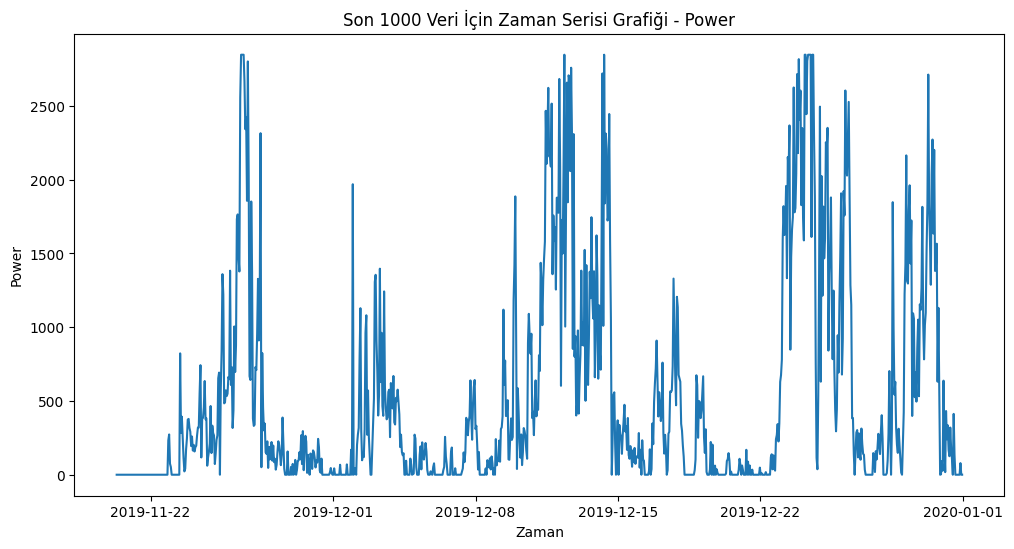

In [25]:
import matplotlib.pyplot as plt

# Son 1000 veriyi gösterme
n_points = 1000

# Zaman Serisi Grafiği (Son X Veri)
plt.figure(figsize=(12, 6))
plt.plot(temizdata.index[-n_points:], temizdata['Power'][-n_points:])
plt.xlabel('Zaman')
plt.ylabel('Power')
plt.title(f'Son {n_points} Veri İçin Zaman Serisi Grafiği - Power')
plt.show()


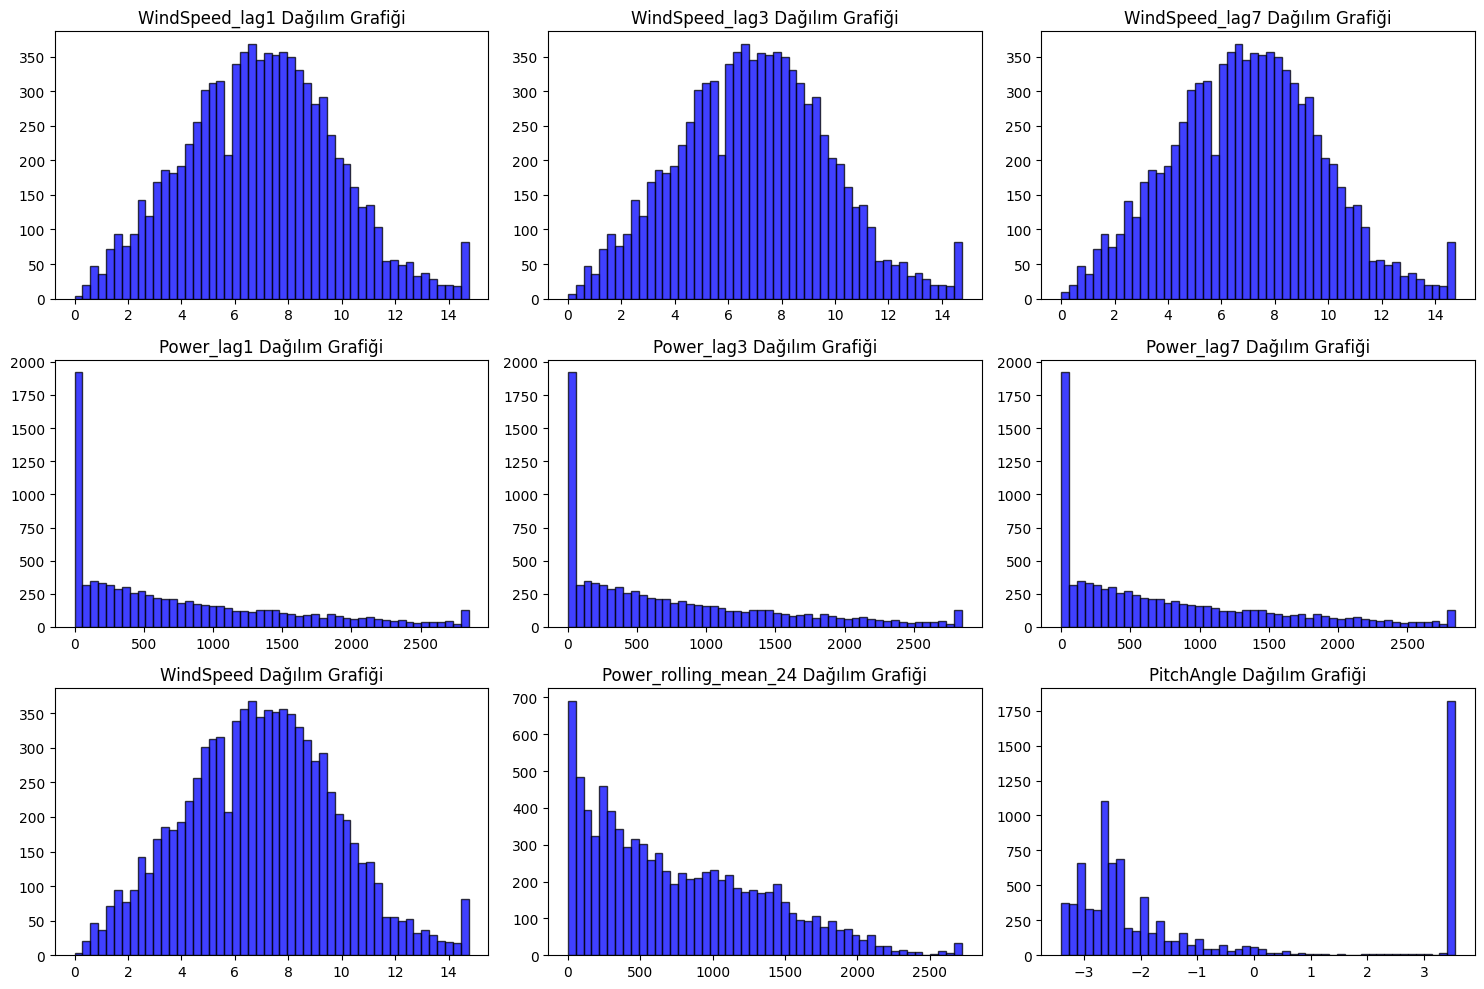

In [28]:
import matplotlib.pyplot as plt

# Dağılım grafikleri için seçilen önemli özellikler
selected_features = [ 'WindSpeed_lag1', 'WindSpeed_lag3', 'WindSpeed_lag7', 
                     'Power_lag1', 'Power_lag3', 'Power_lag7', 'WindSpeed', 'Power_rolling_mean_24', 'PitchAngle']

# Dağılım Grafikleri (Histograms)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 3, i + 1)
    plt.hist(temizdata[feature], bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.title(f'{feature} Dağılım Grafiği')
plt.tight_layout()
plt.show()


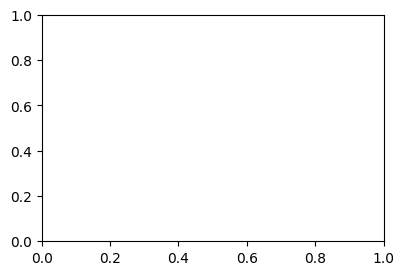

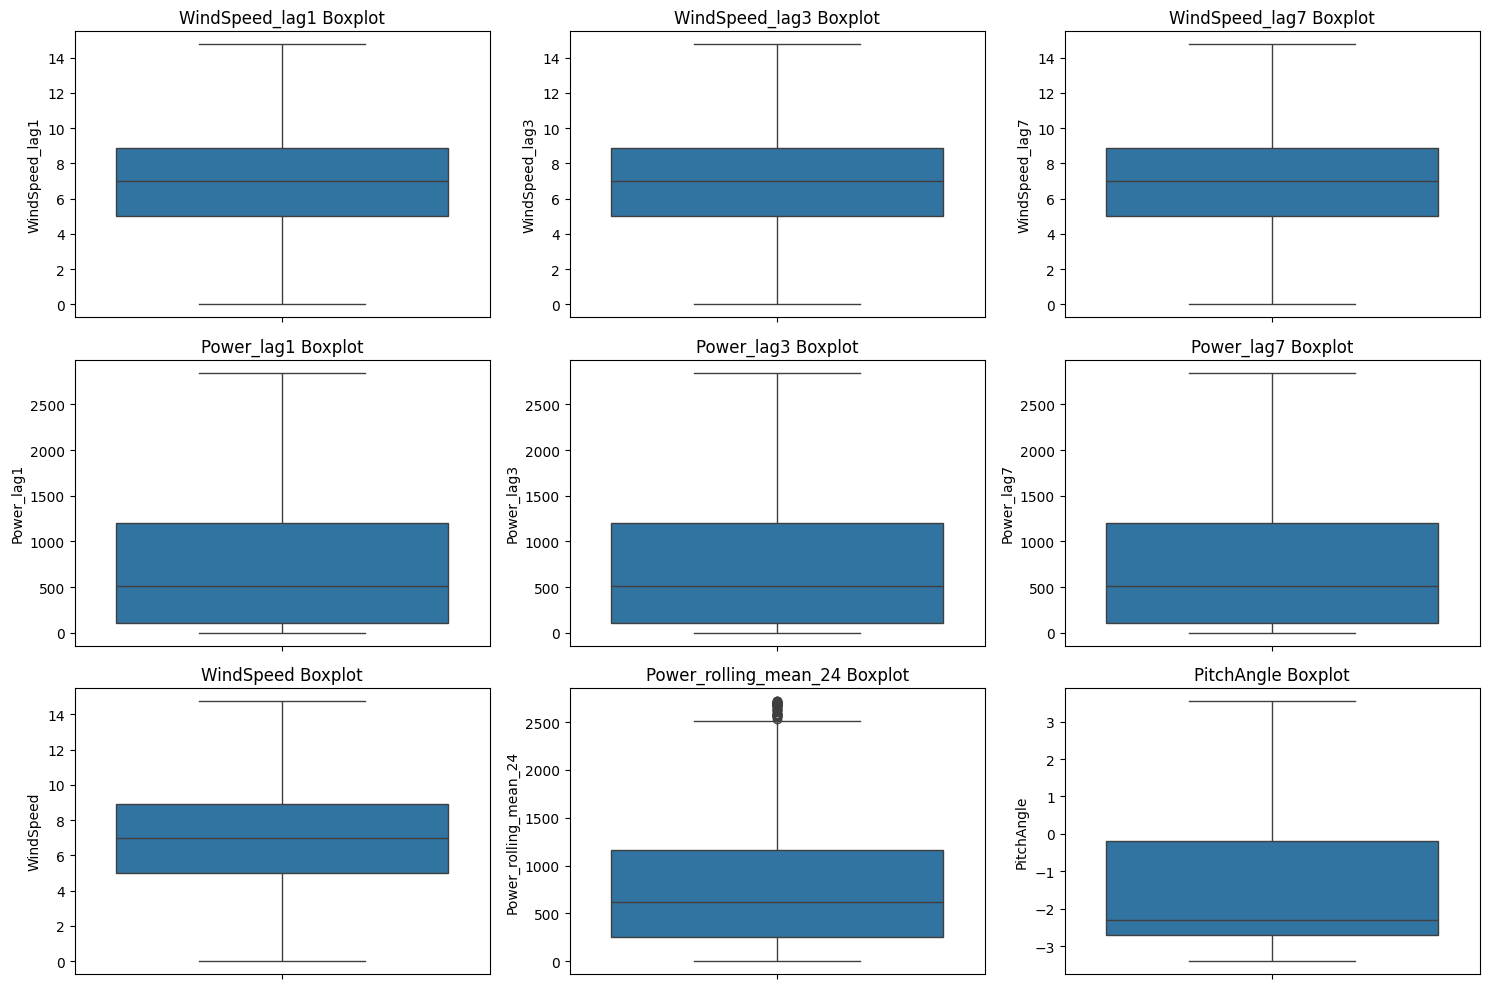

In [32]:
import seaborn as sns

# Boxplot Grafikleri
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=temizdata[feature])
    plt.title(f'{feature} Boxplot')
plt.tight_layout()
plt.show()


In [ ]:
# IQR metodunu kullanarak aykırı değerleri sınırlama
for column in temizdata.columns:
    data_column = temizdata[column]
    q1 = np.percentile(data_column, 25)
    q3 = np.percentile(data_column, 75)
    IQR = q3 - q1
    uplimit = q3 + 1.5 * IQR
    lowlimit = q1 - 1.5 * IQR
    temizdata.loc[temizdata[column] > uplimit, column] = uplimit
    temizdata.loc[temizdata[column] < lowlimit, column] = lowlimit

temizdata.loc[temizdata['Power'] < 0, 'Power'] = 0

In [50]:
from sklearn.preprocessing import MinMaxScaler

# En iyi özellikleri seçme
top_features = performance_df['Feature'][:10].tolist()
X_top_features = temizdata[top_features]

# Normalizasyon
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_top_features)
y_scaled = scaler_y.fit_transform(temizdata['Power'].values.reshape(-1, 1))


In [51]:
import numpy as np

def create_windows(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[(i + window_size):(i + window_size + horizon)])
    return np.array(X), np.array(y)

window_size = 36
horizon = 6

# Power sütunu için veri penceresi oluşturma
X, y = create_windows(y_scaled, window_size, horizon)

# X ve y şekillerini kontrol etme
X.shape, y.shape


((8656, 36, 1), (8656, 6, 1))

In [52]:
from sklearn.model_selection import train_test_split

# Veri setini eğitimseti  ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim setini eğitim ve doğrulama setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((5539, 36, 1),
 (1385, 36, 1),
 (1732, 36, 1),
 (5539, 6, 1),
 (1385, 6, 1),
 (1732, 6, 1))

In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# LSTM modelini oluşturma
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(horizon))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Model eğitimi
history = model_lstm.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Test seti ile tahmin yapma
y_pred_test = model_lstm.predict(X_test)

# Tahminleri geri dönüştürme (normalize edilmişse)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, horizon))

# Performans değerlendirme
test_score_lstm = r2_score(y_test_inverse, y_pred_test)
mse_test_lstm = mean_squared_error(y_test_inverse, y_pred_test)

test_score_lstm, mse_test_lstm


Epoch 1/200


C:\Users\Oğuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0614 - val_loss: 0.0386
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0400 - val_loss: 0.0331
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0344 - val_loss: 0.0313
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0319 - val_loss: 0.0309
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0311 - val_loss: 0.0295
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0311 - val_loss: 0.0290
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0308 - val_loss: 0.0288
Epoch 8/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0294 - val_loss: 0.0287
Epoch 9/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0297 - val_loss: 0.0285
Epoch 10/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 11/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0291 - val_loss: 0.0286
Epoch 12/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

(0.777535269876951, 127907.70597981238)

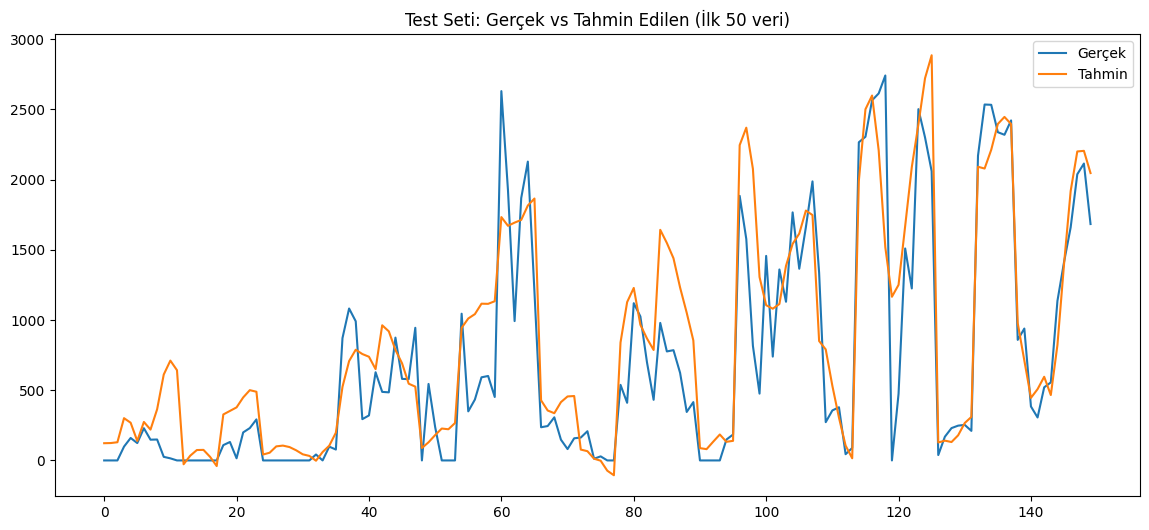

In [61]:
import matplotlib.pyplot as plt

# Test seti için gerçek ve tahmin edilen değerler (ilk 150 veri)
plt.figure(figsize=(14, 6))
plt.plot(y_test_inverse.flatten()[:150], label='Gerçek')
plt.plot(y_pred_test.flatten()[:150], label='Tahmin')
plt.title('Test Seti: Gerçek vs Tahmin Edilen (İlk 150 veri)')
plt.legend()
plt.show()


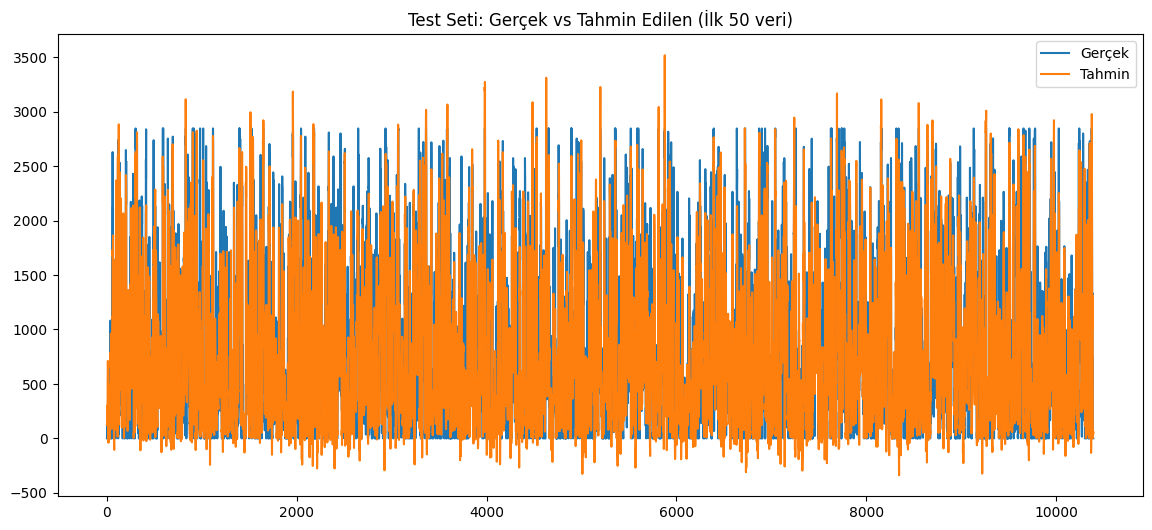

In [62]:
import matplotlib.pyplot as plt

# Test seti için gerçek ve tahmin edilen değerler (ilk 50 veri)
plt.figure(figsize=(14, 6))
plt.plot(y_test_inverse.flatten(), label='Gerçek')
plt.plot(y_pred_test.flatten(), label='Tahmin')
plt.title('Test Seti: Gerçek vs Tahmin Edilen (İlk 50 veri)')
plt.legend()
plt.show()
